# ***Adding requirement for attention layer***

In [1]:
from shutil import copyfile
copyfile(src = "/kaggle/input/attention-py/attention.py", dst = "/kaggle/working/attention.py")

'/kaggle/working/attention.py'

# ***importing required libraries***

In [2]:
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import warnings
from attention import AttentionLayer
pd.set_option("display.max_colwidth", 200)

warnings.filterwarnings("ignore")

Using TensorFlow backend.


# ***Loading dataset to the notebook***

In [3]:
import pandas as pd
data=pd.read_csv("/kaggle/input/cleaned-amazon-reviews/your_file.csv")
data

,Summary,Text,cleaned_text,cleaned_summary
0,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...,bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better,good quality dog food
1,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo"".",product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo,advertised
2,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ...",confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat famil...,delight says
3,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The fl...,looking secret ingredient robitussin believe found got addition root beer extract ordered good made cherry soda flavor medicinal,cough medicine
4,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal.",great taffy great price wide assortment yummy taffy delivery quick taffy lover deal,great taffy
...,...,...,...,...
568396,Will not do without,Great for sesame chicken..this is a good if not better than resturants I have eaten at..My husband loved it..will find other recipes to use this in..,great sesame chicken good better resturants eaten husband loved find recipes use,without
568397,disappointed,"I'm disappointed with the flavor. The chocolate notes are especially weak. Milk thickens it but the flavor still disappoints. This was worth a try but I'll never buy again. I will use what's left,...",I disappointed flavor chocolate notes especially weak milk thickens flavor still disappoints worth try I never buy use left gone time thanks small cans,disappointed
568398,Perfect for our maltipoo,"These stars are small, so you can give 10-15 of those in one training session. I tried to train our dog with ""Ceaser dog treats"", it just made our puppy hyper. If you compare the ingredients, y...",stars small give 10 15 one training session tried train dog ceaser dog treats made puppy hyper compare ingredients know little stars basic food ingredients without preservatives food coloring swee...,perfect maltipoo
568399,Favorite Training and reward treat,These are the BEST treats for training and rewarding your dog for being good while grooming. Lower in calories and loved by all the doggies. Sweet potatoes seem to be their favorite Wet Noses tr...,best treats training rewarding dog good grooming lower calories loved doggies sweet potatoes seem favorite wet noses treat,favorite training reward treat


# ***Information about datatypes and shape of the dataset***

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568401 entries, 0 to 568400
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Summary          568401 non-null  object
 1   Text             568401 non-null  object
 2   cleaned_text     566887 non-null  object
 3   cleaned_summary  567081 non-null  object
dtypes: object(4)
memory usage: 17.3+ MB


# ***Dropping empty rows***

In [5]:
data.replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

# ***Visualization distribution of reviews and summaries***

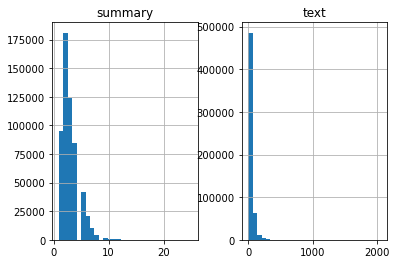

In [6]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

In [7]:
# Calculate the proportion of summaries that are 10 words or fewer
summary_word_limit = 10
short_summary_count = 0
for summary in data['cleaned_summary']:
    # Count the number of words in each summary
    if(len(summary.split()) <= summary_word_limit):
        short_summary_count += 1

# Print the proportion of short summaries
print({short_summary_count / len(data['cleaned_summary'])})

0.9975917972583266


In [8]:
# Calculate the proportion of texts that are 80 words or fewer
text_word_limit = 80
short_text_count = 0
for text in data['cleaned_text']:
    # Count the number of words in each text
    if(len(text.split()) <= text_word_limit):
        short_text_count += 1

# Print the proportion of short texts
print({short_text_count / len(data['cleaned_text'])})

0.8942265018998633


In [9]:
max_text_len=150
max_summary_len=12

# ***getting rid of outliers***

In [10]:
cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
df=pd.DataFrame({'text':short_text,'summary':short_summary})

# ***Adding tokens at the beginning and the end of summary***

In [11]:
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [12]:
for i in range(5):
    print("Review:",df['text'][i])
    print("Summary:",df['summary'][i])
    print("\n")

Review: bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better
Summary: sostok good quality dog food eostok


Review: product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo
Summary: sostok advertised eostok


Review: confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story c lewis lion witch wardrobe treat seduces edmund selling brother sisters witch
Summary: sostok delight says eostok


Review: looking secret ingredient robitussin believe found got addition root beer extract ordered good made cherry soda flavor medicinal
Summary: sostok cough medicine eostok


Review: great taffy great price wide assortment yummy taffy delivery quick taffy lover deal
Su

# ***splitting traing and test set***

In [13]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.1, random_state = 0, shuffle=True) 

# ***prepare a tokenizer for reviews on training data***

In [14]:
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

# ***calculating number of rare and common words in reviews***

In [15]:
# Define a threshold for what we'll consider a 'rare word'
rare_word_threshold = 2

# Initialize counters
rare_word_count = 0        # Number of rare words
total_word_count = 0       # Total number of unique words
rare_word_frequency = 0    # Total frequency of rare words
total_word_frequency = 0   # Total frequency of all words

# Iterate through each word and its count in the tokenizer's word_counts dictionary
for word, count in x_tokenizer.word_counts.items():
    total_word_count += 1              
    total_word_frequency += count      
    
    # If a word's count is below the threshold, it's considered rare
    if count < rare_word_threshold:
        rare_word_count += 1            
        rare_word_frequency += count   

# Calculate and print the percentage of rare words in the vocabulary
print("% of rare words in vocabulary:", (rare_word_count / total_word_count) * 100)

# Calculate and print the total coverage of rare words
print("Total Coverage of rare words:", (rare_word_frequency / total_word_frequency) * 100)

% of rare words in vocabulary: 39.84193157954628
Total Coverage of rare words: 0.2128869748923377


# ***defining tokenizer with most common words for reviews***

In [16]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

In [17]:
x_voc

58154

# ***prepare a tokenizer for summaries on training data***

In [18]:
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

# ***calculating number of rare and common words in summaries***

In [19]:
# Threshold for determining a 'rare word' in summary vocabulary
rare_word_threshold_in_summary = 3

# Initialize counters for summaries
rare_word_count_in_summary = 0        # Number of rare words in summary
total_word_count_in_summary = 0       # Total number of unique words in summary
rare_word_frequency_in_summary = 0    # Total frequency of rare words in summary
total_word_frequency_in_summary = 0   # Total frequency of all words in summary

# Iterate through each word and its count in the summary tokenizer's word_counts dictionary
for word, count in y_tokenizer.word_counts.items():
    total_word_count_in_summary += 1                 
    total_word_frequency_in_summary += count         
    
    # If a word's count in summary is below the threshold, it's considered rare
    if count < rare_word_threshold_in_summary:
        rare_word_count_in_summary += 1              
        rare_word_frequency_in_summary += count      

# Calculate and print the percentage of rare words in the summary vocabulary
print("% of rare words in vocabulary:", (rare_word_count_in_summary / total_word_count_in_summary) * 100)

# Calculate and print the total coverage of rare words in summary
print("Total Coverage of rare words:", (rare_word_frequency_in_summary / total_word_frequency_in_summary) * 100)

% of rare words in vocabulary: 54.88056810845707
Total Coverage of rare words: 0.8551738617933895


# ***defining tokenizer with most common words for summaries***

In [20]:
#prepare a tokenizer for summaries on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

# ***checking word count of start token is equal to length of the training data***

In [21]:
y_tokenizer.word_counts['sostok'],len(y_tr)

(496332, 496332)

# ***deleting the rows that contain only START and END tokens***

In [22]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [23]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

# ***Model building, defining LSTM layers, Encoder and Decoder***

In [24]:
from keras import backend as K 
K.clear_session()

latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.2,recurrent_dropout=0.1)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.2,recurrent_dropout=0.1)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.2,recurrent_dropout=0.1)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.2,recurrent_dropout=0.1)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary() 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 150, 100)     5815400     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 150, 300), ( 481200      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [25]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

# ***monitoring the validation loss***

In [26]:
es = [EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2), 
      ModelCheckpoint('./MyModel_tf',monitor='val_loss', verbose=1,
                      save_best_only=True, mode='min', save_weights_only = False)]

# ***train the model on a batch size of 512 and validate it on the 10% of dataset***

In [27]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=7,callbacks=[es],batch_size=512, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/7
965/965 [==============================] - ETA: 0s - loss: 1.8276
Epoch 00001: val_loss improved from inf to 1.62762, saving model to ./MyModel_tf
965/965 [==============================] - 1534s 2s/step - loss: 1.8276 - val_loss: 1.6276
Epoch 2/7
965/965 [==============================] - ETA: 0s - loss: 1.5558
Epoch 00002: val_loss improved from 1.62762 to 1.48492, saving model to ./MyModel_tf
965/965 [==============================] - 1540s 2s/step - loss: 1.5558 - val_loss: 1.4849
Epoch 3/7
965/965 [==============================] - ETA: 0s - loss: 1.4430
Epoch 00003: val_loss improved from 1.48492 to 1.40817, saving model to ./MyModel_tf
965/965 [==============================] - 1565s 2s/step - loss: 1.4430 - val_loss: 1.4082
Epoch 4/7
965/965 [==============================] - ETA: 0s - loss: 1.3703
Epoch 00004: val_loss improved from 1.40817 to 1.35762, saving model to ./MyModel_tf
965/965 [==============================] - 1546s 2s/step - loss: 1.3703 - val_loss: 1.3

In [28]:
# serialize model to JSON
model_json = model.to_json()
with open("summary.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("summary.h5")
print("Saved model to disk")

Saved model to disk


# ***understanding the behavior of model over time***

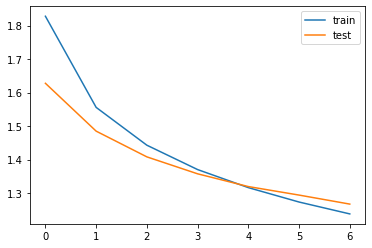

In [29]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# ***convert the index to word for summaries and reviews vocabulary***

In [30]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

# ***Setting up the inference for the encoder and decoder***

In [31]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

# ***Defining a functio for implementation of the inference process***

In [32]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

# ***converting an integer sequence to a word sequence for summaries and reviews***

In [33]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

# ***displaying some summaries generated by the model***

In [34]:
for i in range(0,100):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: flavor strong overwhelming bites used additive stuff mixed pasta buttermilk cream base lends good additive 
Original summary: pretty good supplement 
Predicted summary:  good


Review: purchased mac cheese reviewed best category magazine receive definitely better many organic boxed mac cheese options purchased online currently available local supermarket good saves bit money us catch sale annie organic local store would buy good make organic boxed mac cheese option pantry 
Original summary: good quick mac cheese option 
Predicted summary:  good


Review: like full bodied coffee try something different supplement standard one use coffee perfect purpose timothy rainforest expresso still standard one order 
Original summary: good k cup 
Predicted summary:  good coffee


Review: cat loves things practically hisses random times jumps counter throws bag floor starts swatting bag house put cubbard found cubbard one day crying get insane acts like someone crack im starting question put